<h1>Two-Body Problem</h1>

<h3>A simulation that uses matplotlib to animate the motions of the heavenly bodies.</h3>
<p>Results stored in simulation.gif.</p>

In [254]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter

<h2>Constants and Formulas</h2>
<h3>Scale Factors</h3>

$$\Delta x = 1 \text { AU} = 149,597,870,700m $$

$$\Delta t = 4 \text{ days} = 345,600s $$

### Formulas
$$ F_G = \frac{G\cdot m_1 \cdot m_2}{||\vec{r}||^2} \cdot \frac {\vec{r}}{||\vec{r}||} $$

$$ GPE = \frac{G\cdot m_1 \cdot m_2}{||\vec{r}||} $$

$$ KE = \frac{1}{2} m||\vec{v}||^2 $$

The barycenter is the center of mass of the system, given by:

$$ \vec{s}_{barycenter} = {\sum_{i=1}^N \frac{\vec{s}_i}{m_i}} $$

In [255]:
# —unit scale factors—
L_SCALE = 149597870700 # m/unit length || 1 AU
T_SCALE = 86400 # s/unit time || n Days w. n=1

# Newton's gravitational constant
G = 6.6743e-11 * T_SCALE**2 / L_SCALE**3 # [M]¯¹[L]³[T]¯²

# gravitational force
Fg = lambda m1, m2, r: G * m1 * m2 * r/np.linalg.norm(r)**3 # [M][L][T]¯²

# energy functions  [M][L]²[T]¯²
GPE = lambda m1, m2, r: -G * m1 * m2 / np.linalg.norm(r) # gravitational potential energy
KE = lambda m, v: m * np.linalg.norm(v)**2 / 2 # kinetic energy

def calc_barycenter(particle_list: list):
	"""Calculates the barycenter (center of mass) of the system of particles.
	-----------
	Parameters:
		particle_list: a list of the form [p1, p2, ..., pn] where pi is a tuple of form (mi, si)
	"""
	Σs = np.zeros(3)
	Σm = 0
	for p in particle_list:
		Σs += p[0]*p[1]
		Σm += p[0]
	return Σs/Σm

# def update(dt = 1):


## Initial Conditions

<h3>Orbits</h3>
<p>When looking from outside the Solar system at the Southern hemisphere, the Earth rotates and orbits the sun in a clockwise direction, and the moon rotates and orbits the Earth in a clockwise direction too. As a result, the times it takes for the sun to return to the same position in the sky and for the moon to return to the same phase are slightly longer than the time it takes for the Earth and moon to rotate/orbit 360 degrees, respectively. The Earth takes 23:56 to rotate 360 degrees but the time between two noons is 24:00 because it has also progressed in its orbit. Similarly, the moon completes a full revolution of the Earth in 27.3 days but the time between two full moons is 29.5 days, because the moon phase is defined relative to the sun. 

The moon orbits on a plane inclined by 5.14° relative to the ecliptic.</p>

<a href="https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html">Moon info</a> <br>
<a href="https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html">Earth info</a>

In [256]:
# —initial conditions —
ms = 1.9891E30 # [M]  mass of sun
me = 5.9722E24 # [M]  mass of earth
mm = 7.3477E22 # [M]  mass of moon

s0e = np.array([-1.0167, 0.0, 0.0]) # [L]  initial position of earth (aphelion)
s0s = np.array([0.0, 0.0, 0.0]) # [L]  initial position of sun
s0m = np.array([-1.0143, 0.0, -0.0002176]) # [L]  initial position of moon (perigee)

s0b = calc_barycenter([(me, s0e), (ms, s0s), (mm, s0m)]) # [L]  initial center of mass of the system

ue = np.array([0, 29290 * T_SCALE / L_SCALE, 0]) # [L][T]¯1  inital velocity of earth
us = np.array([0, 0, 0]) # [L][T]¯1  inital velocity of sun
um = np.array([0, 28208 * T_SCALE / L_SCALE, 0]) # [L][T]¯1  inital velocity of moon

# arrays to hold the data
trange = range(190) # [T]  time the simulation runs for, in terms of Δt

e = {'s': [s0e], 'v': [ue]}
s = {'s': [s0s], 'v': [us]}
m = {'s': [s0m], 'v': [um]}
b = {'s': [s0b]}


<h2> Plot Setup <h2>

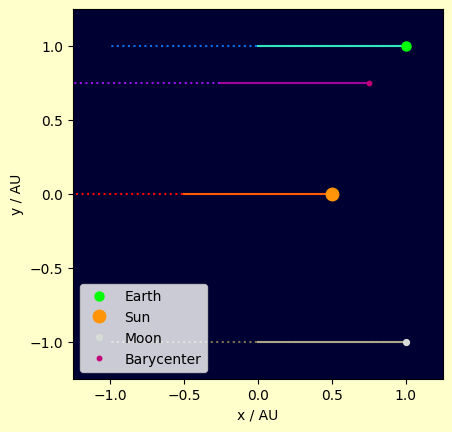

In [257]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect('equal', adjustable='box')
# ax.set_aspect('auto')
fig.patch.set_facecolor('xkcd:ecru')
ax.patch.set_facecolor("xkcd:very dark blue")

# test data to check colors
e_path, = plt.plot([1, -1], [1, 1], ":", color="xkcd:cerulean blue", label="_")
e_trail, = plt.plot([1, 0], [1, 1], "-", color="xkcd:aqua marine", label="_")
earth, = plt.plot([1], [1], "o", color="xkcd:bright green", label="Earth", markersize=6.5)

s_path, = plt.plot([0.5, -1.5], [0, 0], ":", color="xkcd:fire engine red", label="_")
s_trail, = plt.plot([0.5, -0.5], [0, 0], "-", color="xkcd:bright orange", label="_")
sun, = plt.plot([0.5], [0], "o", color="xkcd:tangerine", label="Sun", markersize=9)

m_path, = plt.plot([1, -1], [-1, -1], ":", color="xkcd:grey brown", label="_")
m_trail, = plt.plot([1, 0], [-1,-1], "-", color="xkcd:stone", label="_")
moon, = plt.plot([1], [-1], "o", color="xkcd:light grey", label="Moon", markersize=4.2)

b_path, = plt.plot([0.75, -1.25], [0.75, 0.75], ":", color="xkcd:violet", label="_")
b_trail, = plt.plot([0.75, -0.25], [0.75, 0.75], "-", color="xkcd:barney purple", label="_")
barycenter, = plt.plot([0.75], [0.75], "o", color="xkcd:magenta", label="Barycenter", markersize=3.2)

objs = [
	{
		'id': 'e',
		'path': e_path,
		'trail': e_trail,
		'obj': earth},
	{
		'id': 's',
		'path': s_path,
		'trail': s_trail,
		'obj': sun},
	{
		'id': 'm',
		'path': m_path,
		'trail': m_trail,
		'obj': moon},
	{
		'id': 'b',
		'path': b_path,
		'trail': b_trail,
		'obj': barycenter}]

plt.legend()

plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
# plt.xlim(-0.003, 0.003)
# plt.ylim(-0.003, 0.003)

plt.xlabel("x / AU")
plt.ylabel("y / AU")


md = dict(title="3-Body Problem", artist="Rahul Maru")
writer = PillowWriter(fps=24, metadata=md)


<h1>Algorithm<h1>

## The Leap-Frog Method
The leap-frog integration method involves shifting the velocity calculations by half a time-step (midpoint summation) to improve accuracy. It goes as follows:
$$ \vec{a}_i = \frac{\vec{F}_i}{m} $$
$$ \vec{v}_{i + \frac{1}{2}} = \vec{v}_{i - \frac{1}{2}} + \vec{a}_i \Delta t $$
$$ \vec{s}_{i + 1} = \vec{s}_i + \vec{v}_{i + \frac{1}{2}} \Delta t$$

To set it up for the first timestep:
$$ \vec{v}_{\frac{1}{2}} = \vec{u} + \vec{a}_0 \frac{\Delta t}{2} $$
$$ \vec{s}_{1} = \vec{s}_0 + \vec{v}_{\frac{1}{2}} \Delta t$$



In [258]:
# leapfrog setup
F_es = Fg(me, ms, s0s-s0e)
F_ms = Fg(mm, ms, s0s-s0m)
F_me = Fg(mm, me, s0e-s0m)

e['v'].append(ue + (F_es-F_me)/(2*me))
s['v'].append(us - (F_es+F_ms)/(2*ms))
m['v'].append(um + (F_ms+F_me)/(2*mm))

e['s'].append(s0e + e['v'][-1])
s['s'].append(s0s + s['v'][-1])
m['s'].append(s0m + m['v'][-1])

b['s'].append(calc_barycenter([(me, e['s'][-1]), (ms, s['s'][-1]), (mm, m['s'][-1])]))


<h2>The Simulation</h2>

Run the simulation and store the data.

In [259]:
for t in trange:
	# positions of each body at the last timestep
	se = e['s'][-1]
	ss = s['s'][-1]
	sm = m['s'][-1]

	# distances between bodies
	r_se = ss - se
	r_sm = ss - sm
	r_em = se - sm

	# forces between bodies
	F_es = Fg(me, ms, r_se)
	F_ms = Fg(mm, ms, r_sm)
	F_me = Fg(mm, me, r_em)

	# update velocities
	e['v'].append(e['v'][-1] + (F_es-F_me)/me)
	s['v'].append(s['v'][-1] - (F_es+F_ms)/ms)
	m['v'].append(m['v'][-1] + (F_ms+F_me)/mm)

	e['s'].append(se + e['v'][-1])
	s['s'].append(ss + s['v'][-1])
	m['s'].append(sm + m['v'][-1])

	b['s'].append(calc_barycenter([(me, e['s'][-1]), (ms, s['s'][-1]), (mm, m['s'][-1])]))


Generate the GIF.

In [260]:
with writer.saving(fig, "simulation.gif", 100):
	ex, ey, ez = [[p[i] for p in e['s']] for i in range(3)]
	objs[0]['s'] = {'x': ex, 'y': ey, 'z': ez}
	sx, sy, sz = [[p[i] for p in s['s']] for i in range(3)]
	objs[1]['s'] = {'x': sx, 'y': sy, 'z': sz}
	mx, my, mz = [[p[i] for p in m['s']] for i in range(3)]
	objs[2]['s'] = {'x': mx, 'y': my, 'z': mz}
	bx, by, bz = [[p[i] for p in b['s']] for i in range(3)]
	objs[3]['s'] = {'x': bx, 'y': by, 'z': bz}

	for t in trange:
		tr_lim = max(0, t-12)

		for o in objs:
			# shift the coordinates to be centered at the barycenter
			x = [o['s']['x'][i] - objs[-1]['s']['x'][i] for i in trange]
			y = [o['s']['y'][j] - objs[-1]['s']['y'][j] for j in trange]

			o['path'].set_data(x[:t], y[:t])
			o['trail'].set_data(x[tr_lim:t], y[tr_lim:t])
			o['obj'].set_data([x[t-1]], [y[t-1]])
		

		writer.grab_frame()


### Conservation
In this (and any) physical system, the sums of the linear momentum, angular momentum, and energy must be conserved.
They are calculated by the formulas:
$$\vec{p} = m \vec{v}$$
$$L = \vec{s} \times \vec{p}$$
$$U = KE + GPE$$

Plots the energy, momenta to see if they are indeed conserved.

In [261]:
raise NotImplementedError
# distances between bodies
r_se = e['s']
r_sm = ss - sm
r_em = se - sm

ΣGPE = GPE(me, ms, r_se) + GPE(mm, ms, r_sm) + GPE(mm, me, r_em)
ΣKE = KE(me, ve) + KE(ms, vs) + KE(mm, vm)
U = ΣGPE + ΣKE
Ulist.append(U)

pe = me*ve 
ps = ms*vs
pm = mm*vm
plist.append(np.linalg.norm(pe+ps+pm))

L = np.cross(pe, se) + np.cross(ps, ss) + np.cross(pm, sm)
Llist.append(np.linalg.norm(L))


plt.axhline(0, 0, max(tlist), color = "grey", linestyle="dashed", label="_")

plt.plot(tlist, plist)
plt.plot(tlist, Llist)
plt.plot(tlist, Ulist)

plt.legend(["0", "p", "L", "U"])

plt.ylim(-2e23, 7e23)

plt.show()


NotImplementedError: 